<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SC3000 Assignment: Balancing a Pole on a Cart

## Installing dependencies:

For this assignment, I used gymnasium instead of gym due to dependency conflicts. If any issues occur, consider uninstalling gym and pip install gymnasium instead. All commands are tested in a fresh conda environment so there should not be any errors.

In [1]:
import sys
print(sys.version)

3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]


In [2]:
!py --list

 -V:3.13 *        Python 3.13 (64-bit)
 -V:3.12          Python 3.12 (64-bit)
 -V:3.11          Python 3.11 (64-bit)
 -V:3.8           Python 3.8 (64-bit)
 -V:3.7           Python 3.7 (64-bit)


In [3]:
!"{sys.executable}" -m pip install gymnasium pyvirtualdisplay
!"{sys.executable}" -m pip install gymnasium[classic_control]
!"{sys.executable}" -m pip install --upgrade setuptools
!"{sys.executable}" -m pip install ez_setup
!"{sys.executable}" -m pip install moviepy
!"{sys.executable}" -m pip install optuna
!"{sys.executable}" -m pip install matplotlib
!"{sys.executable}" -m pip install torch
!"{sys.executable}" -m pip install tqdm

## Importing dependencies and define helper functions

In [4]:
import gymnasium as gym
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
import logging
logging.getLogger("gymnasium").setLevel(logging.ERROR)
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import deque
import copy
from tqdm import tqdm


# Function to display the recorded video in the notebook.
def show_video(video_folder="./video"):
    video_files = [os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith(".mp4")]
    if not video_files:
        return "No video found."
    video_file = sorted(video_files)[-1]
    video = open(video_file, "rb").read()
    video_encoded = base64.b64encode(video).decode("ascii")
    return HTML(f"""
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
    </video>
    """)


## Task 1: Development of an RL agent

For Task 1, we will be building a Deep Q Network (DQN).

The Cartpole environment provides a state from a continuous state space, but takes in discrete actions (left or right). As such, building a Q table may not be suitable as it will be unable to cover all possible values that the agent may receive. Hence, a Q Network will be built to allow the agent to handle state values not seen before and generalize across the continuous state space.

As there 4 observed values per state and 2 possible actions, the Q Network will take in 4 inputs and generate 2 outputs. This will allow the network to output its estimated Q-value for each action via each output node. Inside the network, 2 hidden layers with 24 nodes each will use RELU as the activation function before passing on their values to the next node.

To encourage exploration, an epsilon-greedy strategy is employed. At every step, there is a random chance that a random action will be performed, instead of taking the argmax of the network's output. This will allow the network to observe new states and transitions to better learn from the environment.


To stabilise training, several additional measures are used in this notebook.\
&emsp;\
&emsp;&emsp;&emsp;**1. Soft Updating Target network with Main Networks**\
&emsp;&emsp;&emsp;Soft update requires the use of 2 networks, a target network and a main network. The main network will be constantly updated every step taken, while the target \
&emsp;&emsp;&emsp;network will be soft updated by the main network every 5 steps. This delayed and partial update helps the target network reach its final parameters gradually and \
&emsp;&emsp;&emsp;achieve more stable training. \
&emsp;\
&emsp;&emsp;&emsp;**2. Experience Replay**\
&emsp;&emsp;&emsp;Through the addition of a replay buffer, state transitions from previous episodes can be used to train the current network. This random sampling provides the network \
&emsp;&emsp;&emsp;access to state transitions achieved in prior episodes. As such, the effect on estimated Q-values by a significant change to the Q Network is reduced because transitions \
&emsp;&emsp;&emsp;from previous networks are still being used to train the current network, and thus achieves more stable training.\
&emsp;\
&emsp;&emsp;&emsp;**3. Epsilon Decay**\
&emsp;&emsp;&emsp;While the epsilon-greedy approach increases exploration, a constant epsilon will not be useful to the network. Too high of an epsilon will result in the agent making \
&emsp;&emsp;&emsp;random moves every step, while a low epsilon will be significant in aiding the network in learning. To solve this problem, epsilon will decay over episodes, starting from \
&emsp;&emsp;&emsp;1 and decaying by 1.5% every episode to a minimum of 0.005. Epsilon decay will allow training to stabilise as the network learns more about its environment and is \
&emsp;&emsp;&emsp;able to decently estimate Q-values of its state-action pair. \
&emsp;\
Together, the deep neural architecture, target network updates, experience replay, and epsilon decay make the Q Network a Deep Q Network (DQN), enabling it to generalize across continuous state spaces and learn in a stable, efficient manner.\
More on DQN: https://arxiv.org/abs/1312.5602

In [5]:
class QNetwork(nn.Module):
    def __init__(self, state_dim=4, action_dim=2, hidden_dim=24):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, action_dim)
        
        # Apply custom weight initialization
        self.init_weights()

    def init_weights(self):
        # He Initialization for hidden layers
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        
        # Small uniform initialization for the output layer to prevent overestimation bias
        nn.init.uniform_(self.out.weight, -3e-3, 3e-3)

        # Biases to zero for stability
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.out.bias)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        q_values = self.out(x)
        return q_values

def soft_update(target, source, tau):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)


# ---------------------------------------------------------------------------------------------------------------
class ReplayBuffer:
    def __init__(self, max_size, state_dim, action_dim):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, terminated):
        self.buffer.append((state, action, reward, next_state, terminated))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, terminateds = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, terminateds
    
    def size(self):
        return len(self.buffer)

In [6]:
def train_agent(
    gamma=0.98,
    epsilon_start=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.985,
    tau=0.005,
    max_episodes=500,
    max_steps=500,
    batch_size=64,
    replay_buffer_size=1000000,
    lr=1e-3,  
):
    """Train a DQN agent on CartPole-v1 with the given hyperparameters.
       Returns the average reward over all training episodes."""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create the environment
    env = gym.make("CartPole-v1")
    
    # Initialize replay buffer
    replay_buffer = ReplayBuffer(max_size=replay_buffer_size, state_dim=4, action_dim=1)
    
    # Create Q-networks
    QNet = QNetwork().to(device)
    targetQNet = QNetwork().to(device)
    targetQNet.load_state_dict(QNet.state_dict())  # Initialize target with same weights
    
    # Optimizer
    QNet_optimizer = optim.Adam(QNet.parameters(), lr=lr)
    
    # Track rewards
    rewards_list = []

    
    for episode in tqdm(range(max_episodes), desc="Episodes"):
        state, info = env.reset()
        done = False       
        cumulative_reward = 0

        epsilon = max(epsilon_start * (epsilon_decay ** episode), epsilon_min)
        #lr = lr_start * (lr_decay ** episode)
        
        for step in range(max_steps):
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = np.random.randint(0, 2)
            else:
                state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
                action = torch.argmax(QNet(state_tensor)).item()
            
            observation, reward, terminated, truncated, info = env.step(action)
            
            # Store transition in replay buffer
            replay_buffer.add(state, action, reward, observation, terminated)
            
            # Update Q-network if enough samples
            if replay_buffer.size() > batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                
                states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
                actions_tensor = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
                rewards_tensor = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
                next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(device)
                dones_tensor = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)
                
                # Current Q
                current_q_values = QNet(states_tensor).gather(1, actions_tensor)
                
                # Target Q
                with torch.no_grad():
                    next_q_values = targetQNet(next_states_tensor)
                    max_next_q_values = next_q_values.max(1)[0].unsqueeze(1)
                    target_q_values = rewards_tensor + gamma * (1 - dones_tensor) * max_next_q_values
                
                loss = torch.mean((current_q_values - target_q_values) ** 2)
                
                QNet_optimizer.zero_grad()
                loss.backward()
                QNet_optimizer.step()

            if step % 5 == 0:
                soft_update(targetQNet, QNet, tau)
            
            # Update state
            state = observation
            cumulative_reward += reward
            

            
            if terminated or truncated:
                rewards_list.append(cumulative_reward)
                break

        if len(rewards_list) > 100 and np.mean(rewards_list[-30:]) > 450:
            print(episode)
            break
    
    env.close()
    # Return average reward over all episodes
    torch.save(QNet.state_dict(), "model.pth")
    return targetQNet, rewards_list

In [7]:
#import optuna

#def objective(trial):
#    # Suggest values for hyperparameters
#    gamma = trial.suggest_float("gamma", 0.9, 0.99)
#    epsilon_decay = trial.suggest_float("epsilon_decay", 0.95, 0.999)
#    tau = trial.suggest_categorical("tau", [0.001, 0.005, 0.01])
#    lr = trial.suggest_categorical("lr", [1e-3, 3e-4, 1e-4])
    
#    # Train agent with these hyperparameters
#    rewards_list = train_agent(gamma=gamma, epsilon_decay=epsilon_decay, tau=tau, lr = lr)

#    last_50_avg = np.mean(rewards_list[-100:])
    
#    return last_50_avg

#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=50)

#print("Best hyperparameters:", study.best_params)
#print("Best score:", study.best_value)

# Optuna documention: https://optuna.readthedocs.io/en/stable/reference/index.html
# Hyperparameter not included in final code because it takes too long to run

In [8]:
# Hyperparameters
max_episodes = 1000
max_steps = 500
gamma = 0.98
epsilon_start = 1.0
epsilon_min = 0
epsilon_decay = 0.985
batch_size = 64
target_update_freq = 5
tau = 0.005
replay_buffer_size = 1000000
lr = 1e-3
#lr_start = 1e-3
#lr_decay = 0.995

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------------------------------------------------------------

targetQNet, rewards_list = train_agent(
    gamma=gamma,
    epsilon_decay=epsilon_decay,
    tau=tau,
    max_episodes=max_episodes,
    max_steps=max_steps,
    batch_size=batch_size,
    replay_buffer_size=replay_buffer_size,
    lr=lr,
)

print("Training Complete!")

Episodes:  25%|█████████████████▏                                                   | 249/1000 [00:33<01:39,  7.54it/s]

249
Training Complete!


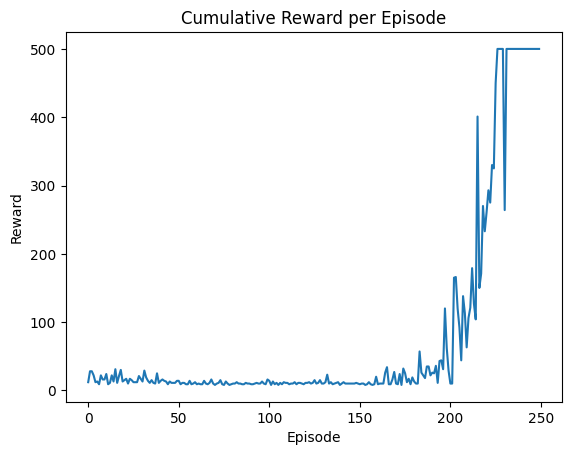

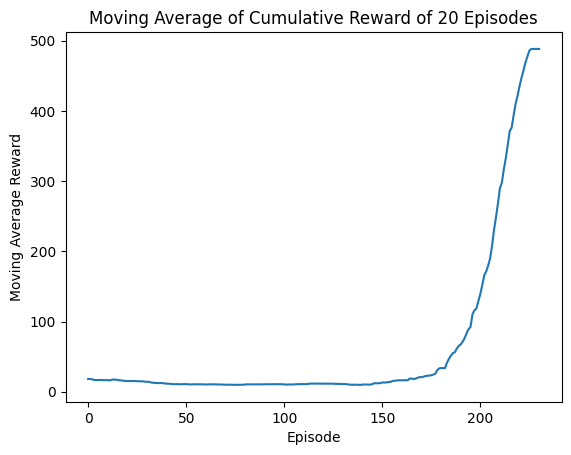

In [9]:
window_size = 1
moving_avg = np.convolve(rewards_list, np.ones(window_size)/window_size, mode='valid')

plt.plot(moving_avg)
plt.title('Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

window_size = 20
moving_avg = np.convolve(rewards_list, np.ones(window_size)/window_size, mode='valid')

plt.plot(moving_avg)
plt.title('Moving Average of Cumulative Reward of 20 Episodes')
plt.xlabel('Episode')
plt.ylabel('Moving Average Reward')
plt.show()

In [10]:
env = gym.make("CartPole-v1")
observation, info = env.reset()
state_tensor = torch.from_numpy(observation).float().unsqueeze(0).to(device)
action = torch.argmax(targetQNet(state_tensor)).item()
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.00029594 -0.00044646 -0.04211865 -0.02158432]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QNetwork().to(device)  # initialize your model
model.load_state_dict(torch.load("model.pth"))
model.eval()

QNetwork(
  (fc1): Linear(in_features=4, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=24, bias=True)
  (out): Linear(in_features=24, out_features=2, bias=True)
)

In [17]:
env = gym.make("CartPole-v1")

num_eval_episodes = 100
eval_rewards = np.array([])

# Run evaluation episodes
for episode in tqdm(range(num_eval_episodes), desc="Evaluating Episodes"):
    # Reset environment. For Gymnasium, this might be: state, _ = env.reset()
    state = env.reset()
    episode_reward = 0
    done = False
    state = state[0]

    while not done:
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action = torch.argmax(model(state_tensor)).item()
        state, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        done = terminated or truncated

    eval_rewards = np.append(eval_rewards, episode_reward)
env.close()

Evaluating Episodes: 100%|███████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.57it/s]


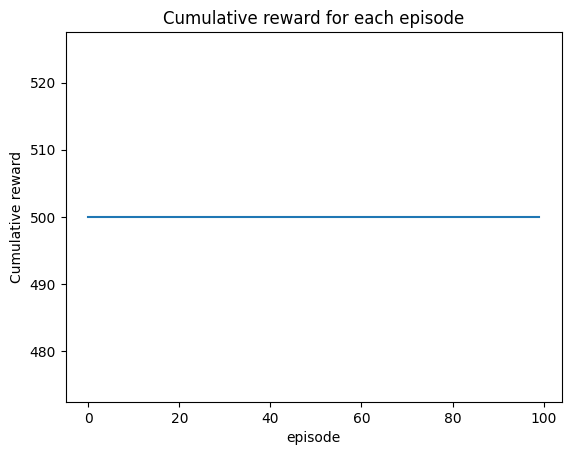

In [18]:
plt.plot(eval_rewards)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [20]:
print("Average cumulative reward:", eval_rewards.mean())
print("Is my agent good enough?", eval_rewards.mean() > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = RecordVideo(
    gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder="./video",
    episode_trigger=lambda episode_id: True  # Record every episode.
)

state, info = env.reset()
done = False

model = QNetwork().to(device)  # initialize your model
model.load_state_dict(torch.load("model.pth"))
model.eval()

while not done:
    # Capture the current frame (an RGB image) from the environment.
    #frame = env.render()  # Returns an np.ndarray of shape (H, W, 3)
    
    # Live display: update the current cell with the frame.
    #plt.imshow(frame)
    #plt.axis("off")
    #clear_output(wait=True)
    #ipythondisplay.display(plt.gcf())
    
    # Prepare the state tensor (make sure to add a batch dimension and send to device)
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    action = torch.argmax(model(state_tensor)).item()  # Greedy action selection
    state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

env.close()



# Display the video in the notebook.
show_video()
